In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession

In [76]:
spark=SparkSession.builder.appName("pre_processing").getOrCreate()

In [77]:
spark_df=spark.read.csv("/home/hdoop/Downloads/data_preprocessing.csv",header=True, inferSchema=True)

<h2>PreProcessing Implementaion Using pandas

In [78]:
df=spark_df.toPandas()


In [79]:
type(df)

pandas.core.frame.DataFrame

In [80]:
df.shape


(10, 4)

In [81]:
df.describe()

,Age,Salary
count,9.000000,9.000000
mean,38.777778,63777.777778
std,7.693793,12265.579662
min,27.000000,48000.000000
25%,35.000000,54000.000000
50%,38.000000,61000.000000
75%,44.000000,72000.000000
max,50.000000,83000.000000


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Country    10 non-null     object 
 1   Age        9 non-null      float64
 2   Salary     9 non-null      float64
 3   Purchased  10 non-null     object 
dtypes: float64(2), object(2)
memory usage: 448.0+ bytes


In [83]:
# chechking for null values
df.isna().sum()

Country      0
Age          1
Salary       1
Purchased    0
dtype: int64

In [84]:
df.isnull().sum()/len(df)*100

Country       0.0
Age          10.0
Salary       10.0
Purchased     0.0
dtype: float64

In [85]:
age_data=df["Age"]

Ploting the Gaussian Distribution For Age

<Axes: xlabel='Age', ylabel='Density'>

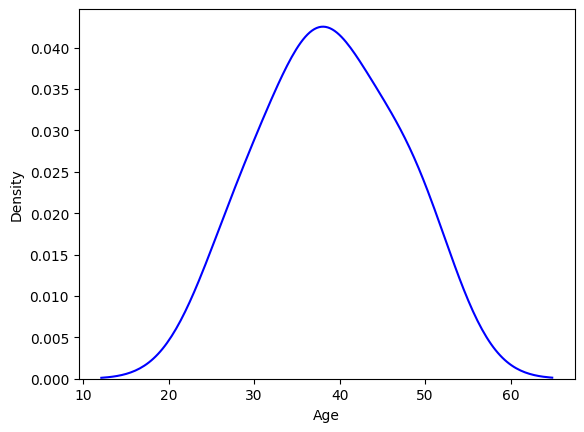

In [86]:
sns.kdeplot(age_data, color='b')

Ploting the Gaussian Distribution For Salary

<Axes: xlabel='Salary', ylabel='Density'>

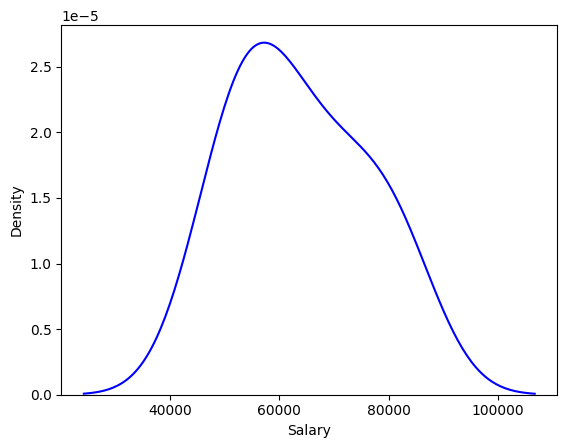

In [87]:
salary_data=df["Salary"]
sns.kdeplot(salary_data, color='b')

Handeling The missing the value

In [88]:
# handeling the missing value
age_mean=df["Age"].mean()
salary_median=df["Salary"].median()

df["Age"].fillna(age_mean,inplace=True)
df["Salary"].fillna(salary_median,inplace=True)

In [89]:
df

,Country,Age,Salary,Purchased
0,France,44.000000,72000.0,No
1,Spain,27.000000,48000.0,Yes
2,Germany,30.000000,54000.0,No
3,Spain,38.000000,61000.0,No
4,Germany,40.000000,61000.0,Yes
5,France,35.000000,58000.0,Yes
6,Spain,38.777778,52000.0,No
7,France,48.000000,79000.0,Yes
8,Germany,50.000000,83000.0,No
9,France,37.000000,67000.0,Yes


In [90]:
df.isna().sum()

Country      0
Age          0
Salary       0
Purchased    0
dtype: int64

Encoding

In [91]:
# encoding 
df["Purchased"]=df["Purchased"].replace({'Yes':1 ,'No': 0})
df

,Country,Age,Salary,Purchased
0,France,44.000000,72000.0,0
1,Spain,27.000000,48000.0,1
2,Germany,30.000000,54000.0,0
3,Spain,38.000000,61000.0,0
4,Germany,40.000000,61000.0,1
5,France,35.000000,58000.0,1
6,Spain,38.777778,52000.0,0
7,France,48.000000,79000.0,1
8,Germany,50.000000,83000.0,0
9,France,37.000000,67000.0,1


Scaling Without any function

In [92]:
# scaling
min_age=df["Age"].min()
max_age=df["Age"].max()

min_salary=df["Salary"].min()
max_salary=df["Salary"].max()

def min_max_scaling(value,min_val, max_val):
    return (value - min_val) / (max_val - min_val)

for age in df["Age"]:
    df["Age"]=df["Age"].replace({age: min_max_scaling(age,min_age,max_age)})

for salary in df["Salary"]:
    df["Salary"]=df["Salary"].replace({salary: min_max_scaling(salary,min_salary,max_salary)})



In [93]:
spark_df.show()

+-------+----+------+---------+
|Country| Age|Salary|Purchased|
+-------+----+------+---------+
| France|  44| 72000|       No|
|  Spain|  27| 48000|      Yes|
|Germany|  30| 54000|       No|
|  Spain|  38| 61000|       No|
|Germany|  40|  null|      Yes|
| France|  35| 58000|      Yes|
|  Spain|null| 52000|       No|
| France|  48| 79000|      Yes|
|Germany|  50| 83000|       No|
| France|  37| 67000|      Yes|
+-------+----+------+---------+



<h2>Implementaion Using Pyspark

In [94]:
import pyspark.ml.feature as ml
from pyspark.ml import Pipeline
import pyspark.sql.functions as F


handeling the missing value

In [95]:

mean_age=spark_df.select(F.mean(F.col("Age"))).collect()[0][0]
mean_salary = spark_df.select(F.mean(F.col("Salary"))).collect()[0][0]
spark_df = spark_df.na.fill(value=mean_age,subset="Age")
spark_df = spark_df.na.fill(value=mean_salary,subset="Salary")
spark_df.show()

+-------+---+------+---------+
|Country|Age|Salary|Purchased|
+-------+---+------+---------+
| France| 44| 72000|       No|
|  Spain| 27| 48000|      Yes|
|Germany| 30| 54000|       No|
|  Spain| 38| 61000|       No|
|Germany| 40| 63777|      Yes|
| France| 35| 58000|      Yes|
|  Spain| 38| 52000|       No|
| France| 48| 79000|      Yes|
|Germany| 50| 83000|       No|
| France| 37| 67000|      Yes|
+-------+---+------+---------+



<h2>ONE-hot encoding

Encoding the y variable

In [96]:
spark_df=spark_df.withColumn('Purchased',F.when(F.col('Purchased') == 'Yes',1).otherwise(0))
spark_df.show()

+-------+---+------+---------+
|Country|Age|Salary|Purchased|
+-------+---+------+---------+
| France| 44| 72000|        0|
|  Spain| 27| 48000|        1|
|Germany| 30| 54000|        0|
|  Spain| 38| 61000|        0|
|Germany| 40| 63777|        1|
| France| 35| 58000|        1|
|  Spain| 38| 52000|        0|
| France| 48| 79000|        1|
|Germany| 50| 83000|        0|
| France| 37| 67000|        1|
+-------+---+------+---------+



converting country to index

In [97]:
country_index=ml.StringIndexer(inputCol="Country",outputCol="Country_index")
index=country_index.fit(spark_df)
country_index_df=index.transform(spark_df)
country_index_df.show()

+-------+---+------+---------+-------------+
|Country|Age|Salary|Purchased|Country_index|
+-------+---+------+---------+-------------+
| France| 44| 72000|        0|          0.0|
|  Spain| 27| 48000|        1|          2.0|
|Germany| 30| 54000|        0|          1.0|
|  Spain| 38| 61000|        0|          2.0|
|Germany| 40| 63777|        1|          1.0|
| France| 35| 58000|        1|          0.0|
|  Spain| 38| 52000|        0|          2.0|
| France| 48| 79000|        1|          0.0|
|Germany| 50| 83000|        0|          1.0|
| France| 37| 67000|        1|          0.0|
+-------+---+------+---------+-------------+



converting index to vector using onehotencoder

In [98]:
encoded=ml.OneHotEncoder(inputCol="Country_index",outputCol="Country_vector",dropLast=False)
encoded_df=encoded.fit(country_index_df).transform(country_index_df)
encoded_df.show()

+-------+---+------+---------+-------------+--------------+
|Country|Age|Salary|Purchased|Country_index|Country_vector|
+-------+---+------+---------+-------------+--------------+
| France| 44| 72000|        0|          0.0| (3,[0],[1.0])|
|  Spain| 27| 48000|        1|          2.0| (3,[2],[1.0])|
|Germany| 30| 54000|        0|          1.0| (3,[1],[1.0])|
|  Spain| 38| 61000|        0|          2.0| (3,[2],[1.0])|
|Germany| 40| 63777|        1|          1.0| (3,[1],[1.0])|
| France| 35| 58000|        1|          0.0| (3,[0],[1.0])|
|  Spain| 38| 52000|        0|          2.0| (3,[2],[1.0])|
| France| 48| 79000|        1|          0.0| (3,[0],[1.0])|
|Germany| 50| 83000|        0|          1.0| (3,[1],[1.0])|
| France| 37| 67000|        1|          0.0| (3,[0],[1.0])|
+-------+---+------+---------+-------------+--------------+



Converting vector to array

In [99]:
from pyspark.ml.functions import vector_to_array
vector_to_arr = encoded_df.select('*', vector_to_array('Country_vector').alias('country_array'))
vector_to_arr.show()

+-------+---+------+---------+-------------+--------------+---------------+
|Country|Age|Salary|Purchased|Country_index|Country_vector|  country_array|
+-------+---+------+---------+-------------+--------------+---------------+
| France| 44| 72000|        0|          0.0| (3,[0],[1.0])|[1.0, 0.0, 0.0]|
|  Spain| 27| 48000|        1|          2.0| (3,[2],[1.0])|[0.0, 0.0, 1.0]|
|Germany| 30| 54000|        0|          1.0| (3,[1],[1.0])|[0.0, 1.0, 0.0]|
|  Spain| 38| 61000|        0|          2.0| (3,[2],[1.0])|[0.0, 0.0, 1.0]|
|Germany| 40| 63777|        1|          1.0| (3,[1],[1.0])|[0.0, 1.0, 0.0]|
| France| 35| 58000|        1|          0.0| (3,[0],[1.0])|[1.0, 0.0, 0.0]|
|  Spain| 38| 52000|        0|          2.0| (3,[2],[1.0])|[0.0, 0.0, 1.0]|
| France| 48| 79000|        1|          0.0| (3,[0],[1.0])|[1.0, 0.0, 0.0]|
|Germany| 50| 83000|        0|          1.0| (3,[1],[1.0])|[0.0, 1.0, 0.0]|
| France| 37| 67000|        1|          0.0| (3,[0],[1.0])|[1.0, 0.0, 0.0]|
+-------+---

Adding encoded colums 

In [100]:
num_categories = len(vector_to_arr.first()['country_array'])   
cols_expanded = [(F.col('country_array')[i].alias(f'{index.labels[i]}')) for i in range(num_categories)]
new_df = vector_to_arr.select('Age', 'Salary','Purchased', *cols_expanded)
new_df.show()

+---+------+---------+------+-------+-----+
|Age|Salary|Purchased|France|Germany|Spain|
+---+------+---------+------+-------+-----+
| 44| 72000|        0|   1.0|    0.0|  0.0|
| 27| 48000|        1|   0.0|    0.0|  1.0|
| 30| 54000|        0|   0.0|    1.0|  0.0|
| 38| 61000|        0|   0.0|    0.0|  1.0|
| 40| 63777|        1|   0.0|    1.0|  0.0|
| 35| 58000|        1|   1.0|    0.0|  0.0|
| 38| 52000|        0|   0.0|    0.0|  1.0|
| 48| 79000|        1|   1.0|    0.0|  0.0|
| 50| 83000|        0|   0.0|    1.0|  0.0|
| 37| 67000|        1|   1.0|    0.0|  0.0|
+---+------+---------+------+-------+-----+



Scaling the age and salary column

In [101]:
feature_column = ["Age", "Salary"]

assemblers = [ml.VectorAssembler(inputCols=[col], outputCol=col + "_vector") for col in feature_column]
scalers = [ml.MinMaxScaler(inputCol=col + "_vector", outputCol=col + "_scaled") for col in feature_column]
pipeline = Pipeline(stages=assemblers+scalers)
scalerModel = pipeline.fit(new_df)
new_data = scalerModel.transform(new_df)

new_data.show()

+---+------+---------+------+-------+-----+----------+-------------+--------------------+--------------------+
|Age|Salary|Purchased|France|Germany|Spain|Age_vector|Salary_vector|          Age_scaled|       Salary_scaled|
+---+------+---------+------+-------+-----+----------+-------------+--------------------+--------------------+
| 44| 72000|        0|   1.0|    0.0|  0.0|    [44.0]|    [72000.0]|[0.7391304347826086]|[0.6857142857142857]|
| 27| 48000|        1|   0.0|    0.0|  1.0|    [27.0]|    [48000.0]|               [0.0]|               [0.0]|
| 30| 54000|        0|   0.0|    1.0|  0.0|    [30.0]|    [54000.0]|[0.13043478260869...|[0.17142857142857...|
| 38| 61000|        0|   0.0|    0.0|  1.0|    [38.0]|    [61000.0]|[0.4782608695652174]|[0.37142857142857...|
| 40| 63777|        1|   0.0|    1.0|  0.0|    [40.0]|    [63777.0]|[0.5652173913043478]|[0.45077142857142...|
| 35| 58000|        1|   1.0|    0.0|  0.0|    [35.0]|    [58000.0]|[0.34782608695652...|[0.2857142857142857]|
|

replacing the columns

In [102]:
new_data=new_data.withColumn("Age",F.col("Age_Scaled"))
new_data=new_data.withColumn("Salary",F.col("Salary_scaled"))

new_data=new_data.drop("Age_vector","Salary_vector","Age_Scaled","Salary_scaled")
new_data.show()

+--------------------+--------------------+---------+------+-------+-----+
|                 Age|              Salary|Purchased|France|Germany|Spain|
+--------------------+--------------------+---------+------+-------+-----+
|[0.7391304347826086]|[0.6857142857142857]|        0|   1.0|    0.0|  0.0|
|               [0.0]|               [0.0]|        1|   0.0|    0.0|  1.0|
|[0.13043478260869...|[0.17142857142857...|        0|   0.0|    1.0|  0.0|
|[0.4782608695652174]|[0.37142857142857...|        0|   0.0|    0.0|  1.0|
|[0.5652173913043478]|[0.45077142857142...|        1|   0.0|    1.0|  0.0|
|[0.34782608695652...|[0.2857142857142857]|        1|   1.0|    0.0|  0.0|
|[0.4782608695652174]|[0.11428571428571...|        0|   0.0|    0.0|  1.0|
|[0.9130434782608695]|[0.8857142857142857]|        1|   1.0|    0.0|  0.0|
|               [1.0]|               [1.0]|        0|   0.0|    1.0|  0.0|
|[0.43478260869565...|[0.5428571428571428]|        1|   1.0|    0.0|  0.0|
+--------------------+---

Spliting the data

In [103]:
train_data, test_data = new_data.randomSplit([0.8, 0.2], seed=42)

# Show the first few rows of the training and testing data
train_data.show()
test_data.show()


+--------------------+--------------------+---------+------+-------+-----+
|                 Age|              Salary|Purchased|France|Germany|Spain|
+--------------------+--------------------+---------+------+-------+-----+
|               [0.0]|               [0.0]|        1|   0.0|    0.0|  1.0|
|[0.13043478260869...|[0.17142857142857...|        0|   0.0|    1.0|  0.0|
|[0.43478260869565...|[0.5428571428571428]|        1|   1.0|    0.0|  0.0|
|[0.4782608695652174]|[0.11428571428571...|        0|   0.0|    0.0|  1.0|
|[0.4782608695652174]|[0.37142857142857...|        0|   0.0|    0.0|  1.0|
|[0.7391304347826086]|[0.6857142857142857]|        0|   1.0|    0.0|  0.0|
|               [1.0]|               [1.0]|        0|   0.0|    1.0|  0.0|
+--------------------+--------------------+---------+------+-------+-----+

+--------------------+--------------------+---------+------+-------+-----+
|                 Age|              Salary|Purchased|France|Germany|Spain|
+--------------------+--

In [104]:
spark.stop()